In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import piecewise_regression
import statsmodels.api as sm
from scipy.stats import spearmanr

from utils.plotting import regplot_lowess_ci

dms_df = pd.read_csv("output/mutations/data.csv")
len(dms_df)

4400

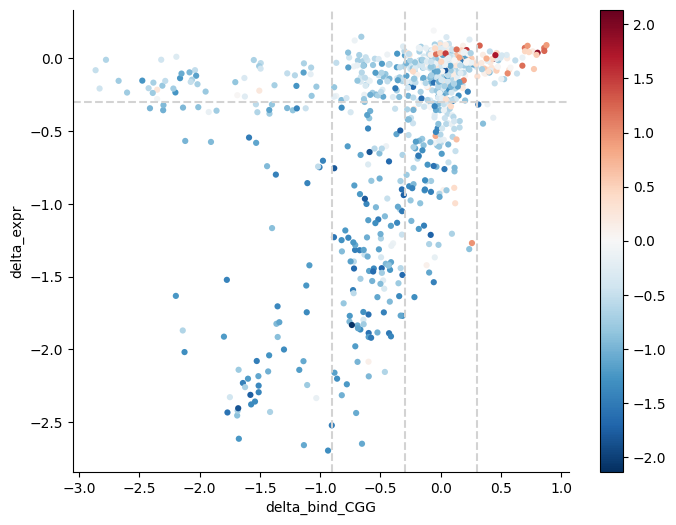

In [4]:
query_str="(single_nt == True) & (WT == False)"
data = dms_df.query(query_str).dropna()
len(data)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    data["delta_bind_CGG"],
    data["delta_expr"],
    c=data["mutation enrichment"],
    cmap="RdBu_r",
    vmin=-np.abs(data["mutation enrichment"]).max(),
    vmax=np.abs(data["mutation enrichment"]).max(),
    s=20,
    linewidth=0  # Remove the edge lines
)

plt.axhline(y=-0.3, color="lightgray", linestyle="--")
plt.axvline(x=-0.9, color="lightgray", linestyle="--")
plt.axvline(x=-0.3, color="lightgray", linestyle="--")
plt.axvline(x=0.3, color="lightgray", linestyle="--")

sns.despine()
plt.colorbar(scatter)
plt.xlabel("delta_bind_CGG")
plt.ylabel("delta_expr")
plt.show()

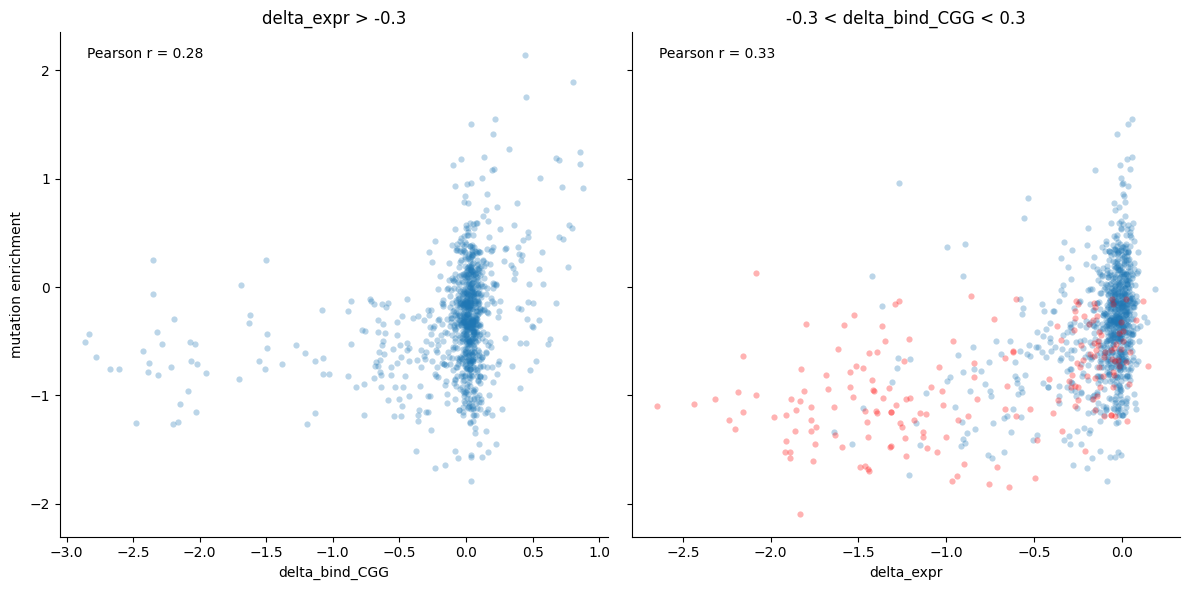

In [27]:
good_expression = data[data["delta_expr"] > -0.3]
near_wt_binders = data[
   (data["delta_bind_CGG"] > -0.3) & (data["delta_bind_CGG"] < 0.3)
]
mediocre_binders = data[
   (data["delta_bind_CGG"] > -0.9) & (data["delta_bind_CGG"] < -0.3)
]
# Calculate Pearson correlations for both plots.
corr1 = np.corrcoef(good_expression["delta_bind_CGG"], good_expression["mutation enrichment"])[0, 1]
corr2 = np.corrcoef(near_wt_binders["delta_expr"], near_wt_binders["mutation enrichment"])[0, 1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
alpha = 0.3

ax1.scatter(
   good_expression["delta_bind_CGG"],
   good_expression["mutation enrichment"],
   s=20,
   linewidth=0,
   alpha=alpha,
)
ax1.text(0.05, 0.95, f"Pearson r = {corr1:.2f}", transform=ax1.transAxes)
ax1.set_xlabel("delta_bind_CGG")
ax1.set_ylabel("mutation enrichment")
ax1.set_title("delta_expr > -0.3")

ax2.scatter(
   near_wt_binders["delta_expr"],
   near_wt_binders["mutation enrichment"],
   s=20,
   linewidth=0,
   alpha=alpha,
)
ax2.text(0.05, 0.95, f"Pearson r = {corr2:.2f}", transform=ax2.transAxes)
ax2.set_xlabel("delta_expr")
ax2.set_title("-0.3 < delta_bind_CGG < 0.3")

ax2.scatter(
   mediocre_binders["delta_expr"],
   mediocre_binders["mutation enrichment"],
   s=20,
   linewidth=0,
   alpha=alpha,
   color="red",
)
#ax2.text(0.05, 0.95, f"Pearson r = {corr2:.2f}", transform=ax3.transAxes)
#ax2.set_xlabel("delta_expr")
#ax3.set_title("-0.9 < delta_bind_CGG < -0.3")

sns.despine()
plt.tight_layout()
plt.show()

Here's the piecewise regression setup we had before:

In [18]:
def do_piecewise_regression(data, measured_var, n_breakpoints):
    delta_thing = data[f"delta_{measured_var}"].to_numpy()
    enrichment = data["mutation enrichment"].to_numpy()

    if n_breakpoints is None:
        ms = piecewise_regression.ModelSelection(delta_thing, enrichment, max_breakpoints=5)
        return ms
    #else:
    pw_fit = piecewise_regression.Fit(delta_thing, enrichment, n_breakpoints=n_breakpoints)

    pw_fit.plot_data(color="grey", alpha=0.5)
    pw_fit.plot_fit(color="red", linewidth=4)
    pw_fit.plot_breakpoints()
    pw_fit.plot_breakpoint_confidence_intervals()
    pw_fit.summary()
    plt.xlabel("$\Delta$ affinity")
    plt.ylabel("mutation enrichment")
    plt.show()
    plt.close()
    return pw_fit


                    Breakpoint Regression Results                     
No. Observations                      917
No. Model Parameters                    4
Degrees of Freedom                    913
Res. Sum of Squares               208.491
Total Sum of Squares              243.608
R Squared                        0.144156
Adjusted R Squared               0.140402
Converged:                           True
                    Estimate      Std Err            t        P>|t|       [0.025       0.975]
----------------------------------------------------------------------------------------------------
const              -0.661289       0.0849      -7.7915       1.8e-14     -0.82786     -0.49472
alpha1            -0.0147571       0.0619     -0.23837         0.812     -0.13626      0.10674
beta1                1.01034         0.12        8.422             -      0.77491       1.2458
breakpoint1        -0.349608         0.08            -             -     -0.50655     -0.19266
-----------------

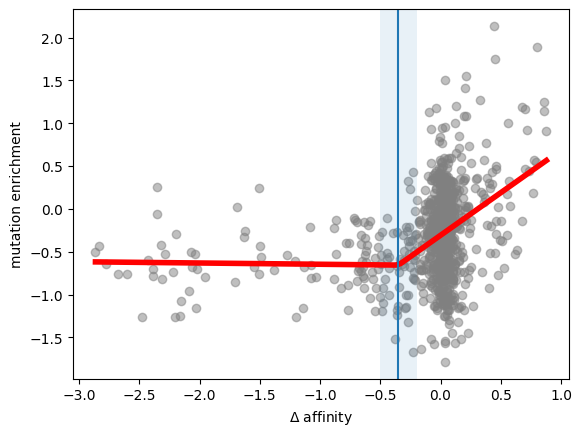

In [33]:
do_piecewise_regression(good_expression, "bind_CGG", 1)


                    Breakpoint Regression Results                     
No. Observations                      859
No. Model Parameters                    4
Degrees of Freedom                    855
Res. Sum of Squares               191.511
Total Sum of Squares              221.195
R Squared                        0.134200
Adjusted R Squared               0.130145
Converged:                           True
                    Estimate      Std Err            t        P>|t|       [0.025       0.975]
----------------------------------------------------------------------------------------------------
const              -0.537805       0.0799      -6.7324      3.06e-11     -0.69459     -0.38101
alpha1               0.27091        0.121       2.2376        0.0255     0.033283      0.50854
beta1                 1.4231        0.303       4.6968             -       0.8284       2.0178
breakpoint1        -0.216658       0.0565            -             -     -0.32759     -0.10572
-----------------

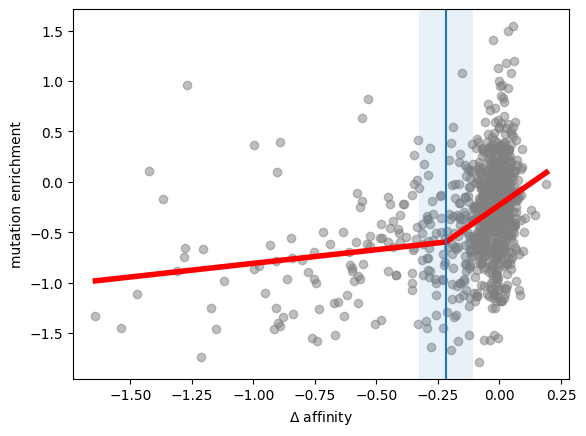

In [34]:
do_piecewise_regression(near_wt_binders, "expr", 1)


                    Breakpoint Regression Results                     
No. Observations                      188
No. Model Parameters                    4
Degrees of Freedom                    184
Res. Sum of Squares               29.2572
Total Sum of Squares              36.9718
R Squared                        0.208661
Adjusted R Squared               0.191363
Converged:                           True
                    Estimate      Std Err            t        P>|t|       [0.025       0.975]
----------------------------------------------------------------------------------------------------
const                -1.0689        0.164      -6.5224      6.49e-10      -1.3922     -0.74557
alpha1            0.00718266        0.105     0.068178         0.946     -0.20067      0.21503
beta1               0.632452         0.21       3.0174             -      0.21892        1.046
breakpoint1        -0.762474        0.218            -             -      -1.1922     -0.33277
-----------------

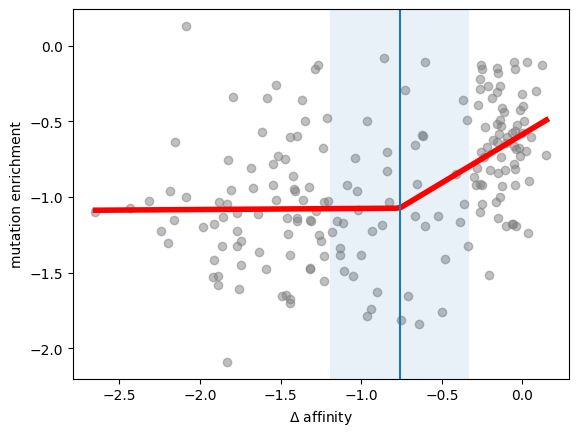

In [38]:
do_piecewise_regression(mediocre_binders, "expr", 1)

And we do the same PW regression as before, with the same result. Note that we get `p=7.93105e-08` for the existence of at least one breakpoint.

In [36]:
pw_fit = do_piecewise_regression("bind_CGG", 1)

TypeError: do_piecewise_regression() missing 1 required positional argument: 'n_breakpoints'

OK, let's look at the residual of delta affinity now. No signal, as expected given than we are plotting the residual:

<Axes: xlabel='delta_bind_CGG', ylabel='enrichment affinity residual'>

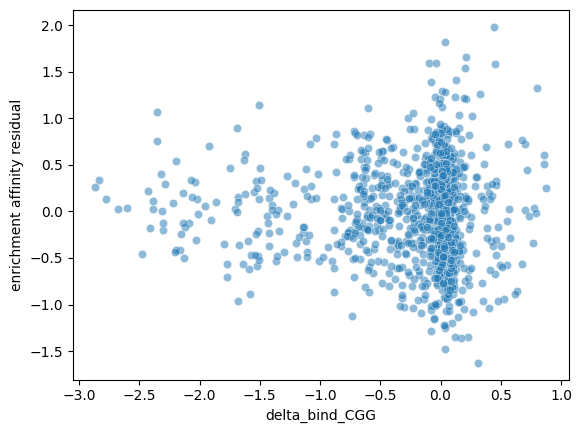

In [5]:
predicted_values = pw_fit.predict(data['delta_bind_CGG'].values)
data['enrichment affinity residual'] = data['mutation enrichment'] - predicted_values

# Plot the residuals 
sns.scatterplot(data=data, x='delta_bind_CGG', y='enrichment affinity residual', alpha=0.5)

Now let's look at the influence of the residual.

Text(0, 0.5, 'enrichment affinity residual')

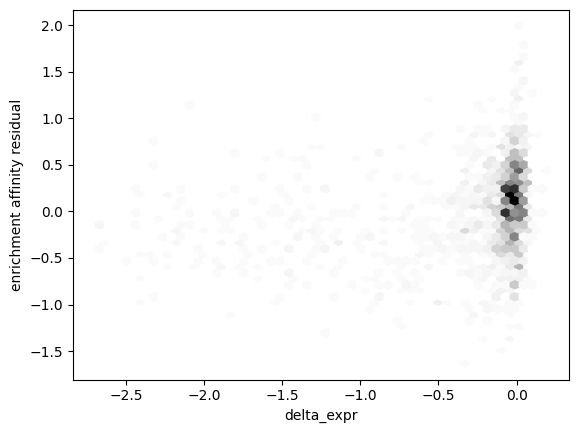

In [6]:
plt.figure()
plt.hexbin(data['delta_expr'], data['enrichment affinity residual'], gridsize=50, cmap='Greys')
plt.xlabel('delta_expr')
plt.ylabel('enrichment affinity residual')

In [7]:
data["delta_avidity"] = data["delta_bind_CGG"] + data["delta_expr"]

rho, _ = spearmanr(data["delta_bind_CGG"], data["mutation enrichment"])
print(f"Spearman's ρ for Δaffinity vs mutation enrichment: {rho:.4f}")

rho, _ = spearmanr(data["delta_expr"], data["mutation enrichment"])
print(f"Spearman's ρ for Δexpression vs mutation enrichment: {rho:.4f}")

rho, _ = spearmanr(data["delta_avidity"], data["mutation enrichment"])
print(f"Spearman's ρ for Δavidity vs mutation enrichment: {rho:.4f}")

rho, _ = spearmanr(data["delta_expr"], data["enrichment affinity residual"])
print(f"Spearman's ρ for Δexpression vs enrichment affinity residual: {rho:.4f}")

Spearman's ρ for Δaffinity vs mutation enrichment: 0.4605
Spearman's ρ for Δexpression vs mutation enrichment: 0.5268
Spearman's ρ for Δavidity vs mutation enrichment: 0.5555
Spearman's ρ for Δexpression vs enrichment affinity residual: 0.2953


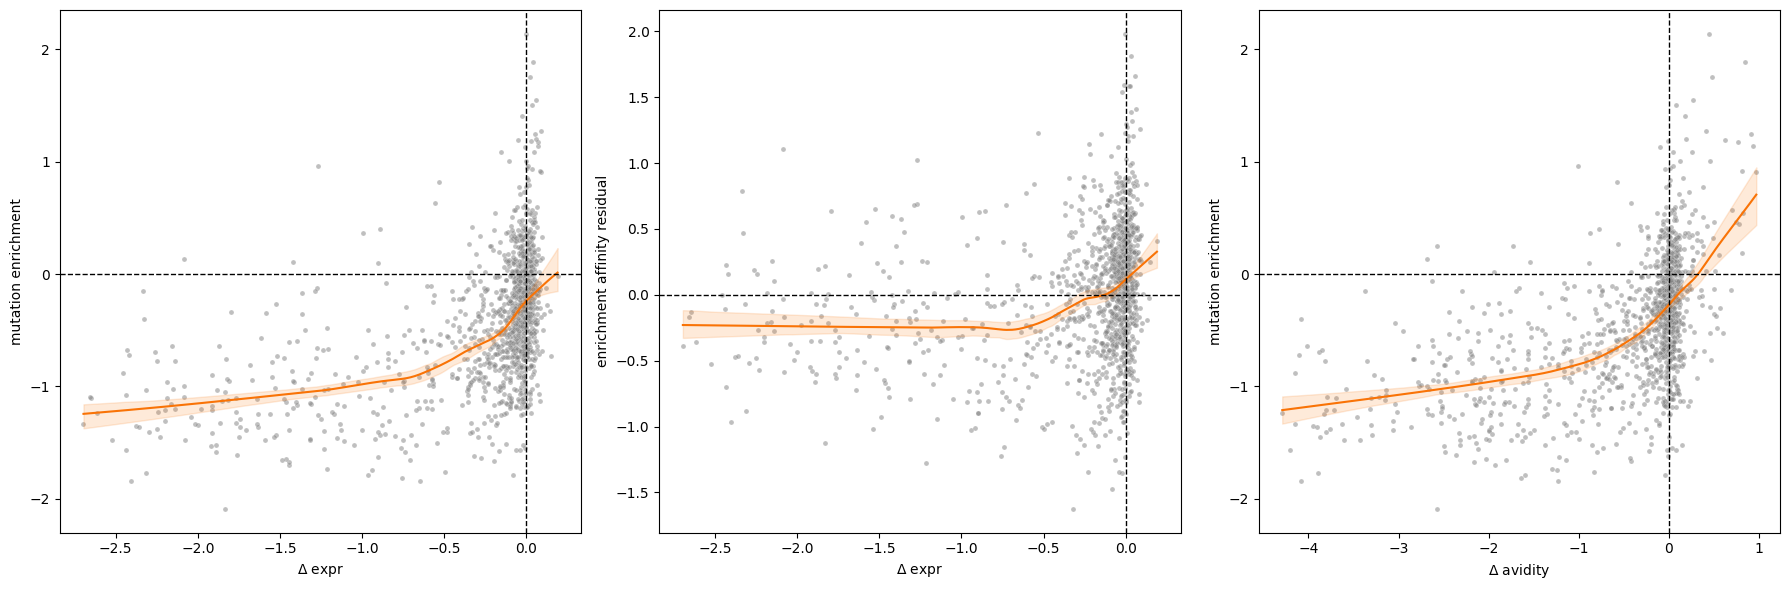

In [8]:
def plot_enrichment_vs_delta(measured_var, outcome_var, ax):
    regplot_lowess_ci(data=data,
            x=f"delta_{measured_var}", y=outcome_var ,
            ci_level=95, n_boot=100,
            scatter_kwargs=dict(s=13, alpha=0.5, color="grey"),
            line_kwargs=dict(color="xkcd:orange"),
            ax=ax,
            )
    ax.axhline(0, color="k", linestyle="--", linewidth=1)
    ax.axvline(0, color="k", linestyle="--", linewidth=1)
    ax.set_xlabel(fr"$\Delta$ {measured_var}")
    ax.set_ylabel(outcome_var)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
plot_enrichment_vs_delta("expr", "mutation enrichment", axs[0])
plot_enrichment_vs_delta("expr", "enrichment affinity residual", axs[1])
plot_enrichment_vs_delta("avidity", "mutation enrichment", axs[2])
plt.tight_layout()
plt.savefig("output/mutations/three-lowess-supp.pdf")